In [1]:
import os

os.environ['SNORKELDB'] = "postgresql://localhost:5432/snorkel?user=snorkel&password=snorkel12345"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [3]:
from ksnorkel import KSUtils

train_sent, dev_sent, test_sent = KSUtils.split_sentences(session)
print("Amount of sentences: {} train, {} dev and {} test".format(len(train_sent), len(dev_sent), len(test_sent)))

Amount of docs: 9738
Document splitted: 3246 train, 3246 dev and 3246 test
Amount of sentences: 33895 train, 34340 dev and 34326 test


In [4]:
from snorkel.models import Candidate, candidate_subclass
from snorkel.candidates import PretaggedCandidateExtractor


GeneChemicalMetabolism = candidate_subclass('GeneChemicalMetabolism', ['gene', 'chemical'])
candidate_gene_chemical_metabolism_extractor = PretaggedCandidateExtractor(GeneChemicalMetabolism, ['Gene', 'Chemical'])

for k, sents in enumerate([train_sent, dev_sent, test_sent]):
    candidate_gene_chemical_metabolism_extractor.apply(sents, split=k, clear=True)
    print("Number of candidates:", session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == k).count())

Clearing existing...


  0%|          | 29/33895 [00:00<01:59, 283.60it/s]

Running UDF...


100%|██████████| 33895/33895 [01:19<00:00, 425.37it/s]


Number of candidates: 17935
Clearing existing...


  0%|          | 34/34340 [00:00<01:41, 336.80it/s]

Running UDF...


100%|██████████| 34340/34340 [01:11<00:00, 477.58it/s]


Number of candidates: 16965
Clearing existing...


  0%|          | 32/34326 [00:00<01:50, 311.51it/s]

Running UDF...


100%|██████████| 34326/34326 [01:21<00:00, 421.22it/s]

Number of candidates: 17138


In [5]:
import gzip

ctd_chem_gene_alternative_interaction = set()
ctd_chem_gene_meta = set()
with gzip.open('data/CTD_chem_gene_ixns.tsv.gz','r') as f:
    for l in f:
        line = str(l).replace('b\'', '').replace('\\n\'', '').replace('\\r','')
        # skip comments
        if line.startswith('#'):
            continue
        #print(line)
        components = line.split('\\t')    
        # add MESH:
        if not components[1].startswith('MESH:'):
            components[1] = "MESH:" + components[1]
            
                
        chemical = components[1]
        gene = components[4]
        key = frozenset((chemical, gene))
                  
        desc = components[8].lower()
        if 'metabol' not in desc and 'increas' not in desc:
            ctd_chem_gene_alternative_interaction.add(key)
            continue
            
        descTyp = components[9]
        if 'increases' not in descTyp and 'affects' not in descTyp:
            ctd_chem_gene_alternative_interaction.add(key)
            continue
        
        #che_name = components[0].replace('b\"','').replace('(','\(').replace(')','\)').lower()
        #regex = '{}[^\]\[]+meta'.format(che_name)
        #regex2 = '{}[^\]\[]+decreased activity'.format(che_name)
        #if re.search(regex, desc) == None and re.search(regex2, desc) == None:
            #print(components[0])
            #print(desc)
            #print()
           # continue

        ctd_chem_gene_meta.add(key)

print('{} chemical-gene assocations read from ChG-CTD_chem_gene_ixns'.format(len(ctd_chem_gene_alternative_interaction)))
print('{} chemical-gene metabolisation read from ChG-CTD_chem_gene_ixns'.format(len(ctd_chem_gene_meta)))

def cand_in_chemical_gene_alternative_interaction(c):
    key = frozenset((c.chemical_cid, c.gene_cid))
    if key in ctd_chem_gene_alternative_interaction:
        return 1
    return -1

def cand_in_chemical_gene_metabolised(c):
    key = frozenset((c.chemical_cid, c.gene_cid))
    if key in ctd_chem_gene_meta:
        return 1
    return -1

588370 chemical-gene assocations read from ChG-CTD_chem_gene_ixns
555728 chemical-gene metabolisation read from ChG-CTD_chem_gene_ixns


In [6]:
import re
from snorkel.lf_helpers import get_tagged_text



# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

metabol_keywords = ['metabolising', 'metabolism', 'metabolisation', 'metabolization', 
                          'increased activity', 'metabolite', 'stimulation',
                          'metabol', 'increase', 'stimulate', 'stimulating', 'induce',
                          'activate', 'potentiate']

def gold_label_function(c):
    if cand_in_chemical_gene_metabolised(c) == 1:
        if re.search(r'' + ltp(metabol_keywords), get_tagged_text(c), re.I):
            return 1
        else:
            return -1
    else:
        return -1


In [7]:
from ksnorkel import KSUtils

KSUtils.add_gold_labels_for_candidates(session, GeneChemicalMetabolism, gold_label_function)

Clearing existing gold labels...
Adding gold labels to training candidates...
Labeld 1741 positive and 16194 negative samples in train
Adding gold labels to develop candidates...
Labeld 1762 positive and 15203 negative samples in dev
Adding gold labels to test candidates...
Labeld 1665 positive and 15473 negative samples in test
Finished - commiting to database...
Commit complete!
Labeld 5168 positive and 46870 negative samples


In [8]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B
)




# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'


metabolisation_samples = ['metabolising', 'metabolism', 'metabolisation', 'metabolization', 
                          'increased activity', 'metabolite', 'stimulation']

def LF_GC_AB_metabolisation_after_AB(c):
    return 1 if (re.search(r'{{A}}.{0,100}' + '{{B}}.{0,100}' + ltp(metabolisation_samples) , get_tagged_text(c), re.I) or
                re.search(r'{{B}}.{0,100}' + '{{A}}.{0,100}' +ltp(metabolisation_samples) , get_tagged_text(c), re.I)) else 0

def LF_GC_metabolisation_before_AB(c):
    return 1 if (rule_regex_search_before_A(c,  ltp(metabolisation_samples) + '.{0,100}', 1) and
                  rule_regex_search_before_B(c, ltp(metabolisation_samples) + '.{0,100}', 1)) else 0



def LF_CG_A_metabolisation_B_far(c):
    return rule_regex_search_btw_AB(c, '.{100,500}' + ltp(metabolisation_samples) + '.{100,500}', -1) 

def LF_GC_B_metabolisation_A_far(c):
    return rule_regex_search_btw_BA(c, '.{100,500}' + ltp(metabolisation_samples) + '.{100,500}', -1)

def LF_GC_A_metabolisation_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabolisation_samples) + '.{0,100}', 1) 

def LF_GC_B_metabolisation_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(metabolisation_samples) + '.{0,100}', 1)

def LG_GC_metabolisation_before_B_near(c):
    return rule_regex_search_before_B(c, ltp(metabolisation_samples) + '.{0,100}', 1)
 
def LG_GC_metabolisation_before_B_far(c):
    return rule_regex_search_before_B(c, ltp(metabolisation_samples) + '.{100,2000}', -1)




metabol_samples = ['metabol', 'increase', 'stimulate', 'stimulating', 'induce', 'activate', 'potentiate']


def LF_GC_A_metabol_B_in_sent(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', 1) 

def LF_GC_B_metabol_A_in_sent(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', 1) 


def LF_GC_B_metabolised_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', 1) 



not_samples = ['no', 'not']

def LF_GC_A_not_metabol_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(not_samples) + '.{0,100}' + ltp(metabol_samples) + '.{0,100}', -1) 


def LF_GC_B_not_metabolised_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(not_samples) + '.{0,100}' + ltp(metabol_samples) + '.{0,100}', -1) 


meta_all_words = []
meta_all_words.extend(metabol_samples)
meta_all_words.extend(metabolisation_samples)
     
def LF_GC_no_metabol(c):
    return -1 if not re.search(r'' + ltp(meta_all_words)  , get_tagged_text(c), re.I) else 0

def LF_GC_metabol_in_sent(c):
    return 1 if re.search(r'' + ltp(meta_all_words), get_tagged_text(c), re.I) else 0



inhibition_samples = ["inhibitor", "inhibition", "auto-inhibition", 'inhibitory', 'suppression']


def LF_GC_AB_before_inhibition(c):
    return -1 if (re.search(r'{{A}}.{0,100}' + '{{B}}.{0,100}' + 'inhibition' , get_tagged_text(c), re.I) or
                re.search(r'{{B}}.{0,100}' + '{{A}}.{0,100}' + 'inhibition' , get_tagged_text(c), re.I)) else 0


def LF_GC_A_supressive_effect_B(c):
    return -1 if  re.search(r'{{A}}.{0,100} supressive'+ '.{0,100} effect .{0,100}' + '{{A}}' , get_tagged_text(c), re.I) else 0


def LF_GC_AB_after_inhibition(c):
    return -1 if (rule_regex_search_before_A(c,  ltp(inhibition_samples) + '.{0,100}', 1) and
                  rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,100}', 1)) else 0

def LF_GC_A_inhibition_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(inhibition_samples) + '.{0,100}', -1) 

def LF_GC_B_inhibition_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(inhibition_samples) + '.{0,100}', -1)

def LG_GC_inhibition_before_B_near(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,100}', -1)
 


inhibits_samples = ["inhibit", 'decrease', 'degrees', 'suppress', 'alleviate', 'reduce']

def LF_GC_A_inhibitis_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(inhibits_samples) + '.{0,100}', -1) 

def LF_GC_A_inhibitis_B_close(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibits_samples) + '.{0,50}', -1) 


def LF_GC_inhibits_in_sent(c):
    return -1 if re.search(r'' + ltp(inhibits_samples)  , get_tagged_text(c), re.I) else 0


# prefer meta if both are included
def LF_GC_meta_and_inhibts(c):
    if LF_GC_inhibits_in_sent(c) == -1 and LF_GC_metabol_in_sent(c) == 1:
        return 1
    return 0


def LF_closer_chem(c):
    # Get distance between chemical and gene
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    gen_start, gen_end = c.gene.get_word_start(), c.gene.get_word_end()
    if gen_start < chem_start:
        dist = chem_start - gen_end
    else:
        dist = gen_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(gen_end, min(len(sent.words), gen_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, gen_start - dist // 2), gen_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0


def LF_closer_gene(c):
    # Get distance between chemical and gene
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    gen_start, gen_end = c.gene.get_word_start(), c.gene.get_word_end()
    if gen_start < chem_start:
        dist = chem_start - gen_end
    else:
        dist = gen_start - chem_end
    # Try to find gene closer than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Gene' and cid != sent.entity_cids[gen_start]:
            return -1
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Gene' and cid != sent.entity_cids[gen_start]:
            return -1
    return 0

                

def LF_CG_inhib_between(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.gene.get_word_start(), c.gene.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find metabol closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        if re.search(r'' + ltp(inhibits_samples), sent.words[i], re.I):
            return -1
    for i in range(max(0, dis_start - dist // 2), dis_start):
        if re.search(r'' + ltp(inhibits_samples), sent.words[i], re.I):
            return -1
    return 0


    
LFs_GC = [
    gold_label_function,
    
    LF_GC_AB_metabolisation_after_AB,
    LF_GC_metabolisation_before_AB,
    LF_CG_A_metabolisation_B_far,
    LF_GC_B_metabolisation_A_far,
    LF_GC_A_metabolisation_B,
    LF_GC_B_metabolisation_A,
    LG_GC_metabolisation_before_B_near,
    LG_GC_metabolisation_before_B_far,
    LF_GC_A_metabol_B_in_sent,
    LF_GC_B_metabol_A_in_sent,
    LF_GC_B_metabolised_A,
    LF_GC_A_not_metabol_B,
    LF_GC_B_not_metabolised_A,
    LF_GC_no_metabol,
    LF_GC_metabol_in_sent,
    LF_GC_AB_before_inhibition,
    LF_GC_A_supressive_effect_B,
    LF_GC_AB_after_inhibition,
    LF_GC_A_inhibition_B,
    LF_GC_B_inhibition_A,
    LG_GC_inhibition_before_B_near,
    LF_GC_A_inhibitis_B,
    LF_GC_A_inhibitis_B_close,
    LF_GC_inhibits_in_sent,
    LF_GC_meta_and_inhibts,
    LF_closer_chem,
    LF_closer_gene,
    LF_CG_inhib_between
]

In [9]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs_GC)

%time L_train = labeler.apply(lfs=LFs_GC, parallelism=10)
L_train

  0%|          | 0/17935 [00:00<?, ?it/s]

Clearing existing...
Running UDF...


100%|██████████| 17935/17935 [02:44<00:00, 109.00it/s]


CPU times: user 48.9 s, sys: 5.78 s, total: 54.7 s
Wall time: 2min 45s


<17935x29 sparse matrix of type '<class 'numpy.int64'>'
	with 62113 stored elements in Compressed Sparse Row format>

In [10]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
gold_label_function,0,1.000000,1.000000,0.318093
LF_GC_AB_metabolisation_after_AB,1,0.005966,0.005966,0.005185
LF_GC_metabolisation_before_AB,2,0.000000,0.000000,0.000000
LF_CG_A_metabolisation_B_far,3,0.000000,0.000000,0.000000
LF_GC_B_metabolisation_A_far,4,0.000781,0.000781,0.000781
LF_GC_A_metabolisation_B,5,0.004628,0.004628,0.004014
LF_GC_B_metabolisation_A,6,0.005687,0.005687,0.004684
LG_GC_metabolisation_before_B_near,7,0.006022,0.006022,0.005631
LG_GC_metabolisation_before_B_far,8,0.001951,0.001951,0.001951
LF_GC_A_metabol_B_in_sent,9,0.031057,0.031057,0.026206


In [11]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)
train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


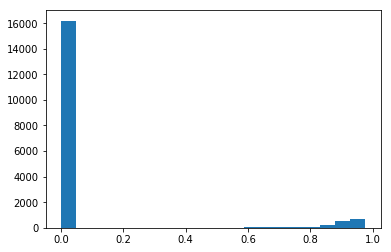

In [12]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [13]:
from snorkel.annotations import load_gold_labels

L_dev = labeler.apply_existing(split=1)
L_test = labeler.apply_existing(split=2)
L_gold_dev = load_gold_labels(session, annotator_name='gold',split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

  0%|          | 2/16965 [00:00<15:55, 17.75it/s]

Clearing existing...
Running UDF...


  0%|          | 0/17138 [00:00<?, ?it/s]

Clearing existing...
Running UDF...


100%|██████████| 17138/17138 [05:54<00:00, 48.37it/s]


In [14]:
#from snorkel.learning import GenerativeModel
#from snorkel.learning import RandomSearch
#from snorkel.learning.structure import DependencySelector


#MAX_DEPS = 5

#ds = DependencySelector()
#deps = ds.select(L_train, threshold=0.1)
#deps = set(list(deps)[0:min(len(deps), MAX_DEPS)])

#print("Using {} dependencies".format(len(deps)))



# use random search to optimize the generative model
#param_grid = {
#    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6],
#    'decay'     : [0.9, 0.95],
#    'epochs'    : [50,100,150],
#    'reg_param' : [1e-3],
#}

#model_class_params = {'lf_propensity' : False }#, 'deps': deps}

#searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=10, model_class_params=model_class_params)
#%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev) #, deps=deps)
#run_stats

In [15]:
train_marginals = gen_model.marginals(L_train)

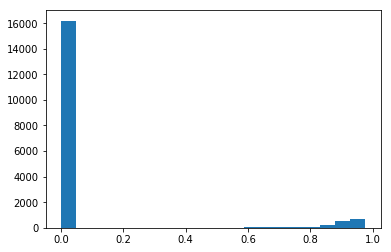

In [16]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [17]:
from snorkel.annotations import save_marginals

dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

%time save_marginals(session, L_train, train_marginals)

Scores (Un-adjusted)
Pos. class accuracy: 0.998
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.998
F1                   0.999
----------------------------------------
TP: 1758 | FP: 0 | TN: 15203 | FN: 4

Saved 17935 marginals
CPU times: user 14.7 s, sys: 848 ms, total: 15.5 s
Wall time: 22.8 s


In [18]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.998
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.998
F1                   0.999
----------------------------------------
TP: 1661 | FP: 0 | TN: 15473 | FN: 4



In [19]:
print("Load all ChemicalGeneMetabolism candidates from db...")
train_cands = session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == 0).order_by(GeneChemicalMetabolism.id).all()
dev_cands   = session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == 1).order_by(GeneChemicalMetabolism.id).all()
test_cands  = session.query(GeneChemicalMetabolism).filter(GeneChemicalMetabolism.split == 2).order_by(GeneChemicalMetabolism.id).all()


all_cands = []
all_cands.extend(train_cands)
all_cands.extend(dev_cands)
all_cands.extend(test_cands)


print("{} {} {}".format(len(train_cands), len(dev_cands), len(test_cands)))
print("Amount of all candidates: {}".format(len(all_cands)))

Load all ChemicalGeneMetabolism candidates from db...
17935 16965 17138
Amount of all candidates: 52038


In [20]:
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_gold_labels
import torch
import torch.nn as nn

#train_kwargs = #{
#    'lr':            0.01,#
#    'embedding_dim': 75,
#    'hidden_dim':    75,
#    'n_epochs':      1,
#    'dropout':       0.25,
#    'seed':          1701
#}

train_kwargs = {
    'lr':            0.0010,
    'embedding_dim': 50,
    'hidden_dim':    50,
    'n_epochs':      100,
    'dropout':       0.25,
    'rebalance':     0.0,
    'seed':          1701
}


lstm = LSTM(n_threads=10)
#lstm.loss = torch.nn.KLDivLoss()

In [21]:
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=17935  #epochs=100  batch size=64
[LSTM] Epoch 2 (358.63s)	Average loss=0.232036	Dev F1=6.44
[LSTM] Epoch 3 (566.01s)	Average loss=0.184860	Dev F1=13.17
[LSTM] Epoch 4 (787.77s)	Average loss=0.157966	Dev F1=21.35
[LSTM] Epoch 5 (1029.02s)	Average loss=0.144116	Dev F1=23.90
[LSTM] Epoch 6 (1261.55s)	Average loss=0.135454	Dev F1=19.49
[LSTM] Epoch 7 (1456.80s)	Average loss=0.128556	Dev F1=19.61
[LSTM] Epoch 8 (1692.27s)	Average loss=0.121851	Dev F1=22.68
[LSTM] Epoch 9 (1936.39s)	Average loss=0.117481	Dev F1=30.09
[LSTM] Epoch 10 (2190.59s)	Average loss=0.111779	Dev F1=26.40
[LSTM] Epoch 11 (2443.98s)	Average loss=0.108313	Dev F1=30.63
[LSTM] Epoch 12 (2702.06s)	Average loss=0.105575	Dev F1=25.53
[LSTM] Epoch 13 (2960.77s)	Average loss=0.104372	Dev F1=27.98
[LSTM] Epoch 14 (3221.30s)	Average loss=0.094917	Dev F1=25.92
[LSTM] Epoch 15 (3482.62s)	Average loss=0.094921	Dev F1=27.43
[LSTM] Epoch 16 (3742.67s)	Average loss=0.090938	Dev F1=27.74
[LSTM] Epoc

In [22]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.247
Neg. class accuracy: 0.959
Precision            0.393
Recall               0.247
F1                   0.304
----------------------------------------
TP: 412 | FP: 637 | TN: 14836 | FN: 1253



In [23]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.393, Recall: 0.247, F1 Score: 0.304


In [25]:
lstm.save_marginals(session, all_cands)

Saved 52038 marginals


In [26]:
from snorkel.models.candidate import Marginal
from snorkel.models import Document, Sentence


print("Storing candidate labels into result file...")
amount_of_candidates = session.query(Candidate).count()
print("Amount of candidates: {}".format(amount_of_candidates))

all_sents = []
all_sents.extend(train_sent)
all_sents.extend(dev_sent)
all_sents.extend(test_sent)


Storing candidate labels into result file...
Amount of candidates: 52038


In [27]:
header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('sentence_id', 'cand_id','gene_cid', 'gene_span', 'chemical_cid', 'chemical_span', 'sentence')
%time KSUtils.save_binary_relation_confusion_matrix_as_tsv('results/gene_chemical_metabolisation.tsv', session, all_cands, all_sents, header_str, 'gene_cid', 'chemical_cid')

Storing candidate labels into result file: results/gene_chemical_metabolisation.tsv
Amount of candidates: 52038
Load mariginals from db...
Marginals loaded!
Load gold labels from db...
Gold labels loaded!
Start writing files...
Saved 2546 TP, 1283 FP, 45587 TN, 2622 FN facts in files.
CPU times: user 1min 48s, sys: 3.95 s, total: 1min 52s
Wall time: 2min 13s


In [28]:
header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('document_id', 'sentence_id', 'cand_id','gene_cid', 'gene_span', 'chemical_cid', 'chemical_span')
%time KSUtils.save_binary_relation_as_tsv('results/chemical_gene_metabolism.tsv', session, all_cands, all_sents, header_str, 'gene_cid', 'chemical_cid')

Storing candidate labels into result file: results/chemical_gene_metabolism.tsv
Amount of candidates: 52038
Load mariginals from db...
Marginals loaded!
Building sentence to document map...
Map built!
Saved 3829 positive predicitions for binary relation!
CPU times: user 1min 30s, sys: 2.92 s, total: 1min 33s
Wall time: 1min 53s


In [29]:
lstm.save("gene_chemical_metabolism.lstm")

[LSTM] Model saved as <gene_chemical_metabolism.lstm>
